# Process Landsat 8 imagery for Amery Doline Paper

The Landsat 8 data is all on S3, so we don't need any pre-downloaded data here. 

- RGB true-color composite pan-sharpening from the original band data
- cropping to our rough region of interest around the Doline
- exporting as 8-bit

In [1]:
%matplotlib notebook
import rasterio as rio
from rasterio import plot
from rasterio import warp
from rasterio.enums import ColorInterp
from rasterio.windows import Window
from rasterio.windows import from_bounds
from rasterio.transform import TransformMethodsMixin
from rasterio.enums import Resampling
from rasterio.warp import reproject
import os
from os import listdir, makedirs
from os.path import isfile, join, exists
# needed to set environment variables to make it work
os.environ["GDAL_DATA"] = "/home/parndt/anaconda3/envs/geo_py37/share/gdal"
os.environ["PROJ_LIB"] = "/home/parndt/anaconda3/envs/geo_py37/share/proj"
import pandas as pd
import geopandas as gpd
import numpy as np
import earthpy as et
import earthpy.spatial as es
from scipy import interpolate
from scipy.ndimage import gaussian_filter
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle as pkl
from mpl_toolkits.basemap import Basemap
from readers.read_HDF5_ATL03 import read_HDF5_ATL03
from readers.read_ICESat2_ATL06 import read_HDF5_ATL06
from readers.get_ATL03_x_atc_corrected import get_ATL03_x_atc_corrected
import warnings
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore",category=RuntimeWarning)
from matplotlib.ticker import FormatStrFormatter
from curve_intersect import *
import shapely
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
from rio_pansharpen import worker

## helper functions for pansharpening

In [2]:
def calculateRatio(rgb, pan, weight):
    return pan / ((rgb[0] + rgb[1] + rgb[2] * weight) / (2 + weight))

def Brovey(rgb, pan, weight, pan_dtype):
    with np.errstate(invalid='ignore', divide='ignore'):
        ratio = calculateRatio(rgb, pan, weight)
    with np.errstate(invalid='ignore'):
        sharp = np.clip(ratio * rgb, 0, np.iinfo(pan_dtype).max)
        return sharp.astype(pan_dtype), ratio
    
def _upsample(rgb, panshape, src_aff, src_crs, to_aff, to_crs):
    up_rgb = np.empty((rgb.shape[0], panshape[0],panshape[1]), dtype=rgb.dtype)
    reproject(rgb, up_rgb,src_transform=src_aff,src_crs=src_crs,dst_transform=to_aff,
              dst_crs=to_crs,resampling=Resampling.bilinear)
    return up_rgb

def _create_apply_mask(rgb):
    color_mask = np.all(np.rollaxis(rgb, 0, 3) != 0,axis=2).astype(np.uint16) * np.iinfo(np.uint16).max
    masked_rgb = np.array([np.minimum(band, color_mask) for band in rgb])
    return masked_rgb

def pansharpen(vis, vis_transform, pan, pan_transform, pan_dtype, r_crs, dst_crs, weight=0.2, method="Brovey", src_nodata=0):
    rgb = _upsample(_create_apply_mask(vis), pan.shape, vis_transform, r_crs, pan_transform, dst_crs)
    # Main Pansharpening Processing
    if method == "Brovey":
        pansharp, _ = Brovey(rgb, pan, weight, pan_dtype)
    # TODO: add other methods
    return pansharp

## a function for pansharpening

In [80]:
def pansharpLandsatS3(filename, localpath, limits, showimage=False, factor=2.3):
    
    S3dir = 's3://landsat-pds/c1/L8'
    WRS_path = filename[10:13]
    WRS_row = filename[13:16]
    
    # open Landsat 8 bands for red, green, blue, and panchromatic
    r = rio.open('%s/%s/%s/%s/%s_B%d.TIF' % (S3dir,WRS_path,WRS_row,filename,filename,4))
    g = rio.open('%s/%s/%s/%s/%s_B%d.TIF' % (S3dir,WRS_path,WRS_row,filename,filename,3))
    b = rio.open('%s/%s/%s/%s/%s_B%d.TIF' % (S3dir,WRS_path,WRS_row,filename,filename,2))
    p = rio.open('%s/%s/%s/%s/%s_B%d.TIF' % (S3dir,WRS_path,WRS_row,filename,filename,8))
    
    # set the appropriate windows for reading data
    left = limits[0]
    right = limits[1]
    bottom = limits[2]
    top = limits[3]
    wd = from_bounds(left, bottom, right, top, r.transform)
    wdv = np.array([wd.col_off,wd.row_off,wd.width,wd.height]).astype(int)
    wdp = wdv * 2
    wdpan = Window(col_off=wdp[0],row_off=wdp[1],width=wdp[2],height=wdp[3])
    wdrgb = Window(col_off=wdv[0],row_off=wdv[1],width=wdv[2],height=wdv[3])
    
    # read the windowed data and put r,g,b into vis array
    pan = p.read(1,window=wdpan)
    vis = np.zeros(shape=(3,wdrgb.height,wdrgb.width))
    for i,vband in enumerate([r,g,b]):
        vis[i,:,:] = vband.read(1,window=wdrgb)
    
    # calculate the appropriate transforms for windowed rasters
    pan_transform = p.window_transform(wdpan)
    vis_transform = r.window_transform(wdrgb)
    
    # call to the pansharpen function to calculate the pansharpened 16-bit RGB array
    pansharpened = pansharpen(vis=vis, vis_transform=vis_transform, pan=pan, pan_transform=pan_transform,
                   pan_dtype=pan.dtype, r_crs=r.crs, dst_crs=p.crs)
    
    # set up true color cropped 8-bit image for export
    outname = localpath + filename + '_pansharp_cropped_tci_8bit.tiff'
    trueColor = rio.open(outname, 'w', driver='Gtiff',
                         width=wdpan.width, height=wdpan.height,
                         count=3,
                         crs=p.crs,
                         #transform=bd.transform,
                         transform = pan_transform,
                         dtype='uint8')
    trueColor.profile['photometric'] = "RGB"
    trueColor.colorinterp = [ColorInterp.red, ColorInterp.green, ColorInterp.blue]
    
    # convert to 8-bit and write to output file
    for ibd in [1, 2, 3]:
        # bd = img.read(ibd, window=wd)
        bd = pansharpened[ibd-1,:,:]
        bd = bd.astype(np.double)
        # bd = bd * factor
        bd = factor * np.iinfo(np.uint8).max * bd / np.iinfo(np.uint16).max
        bd[bd>np.iinfo(np.uint8).max] = np.iinfo(np.uint8).max
        bd = bd.astype(np.uint8)
        trueColor.write(bd,ibd)
    trueColor.close()
    print('Wrote file %s.' % outname)

    # plot 
    if showimage:
        fn = outname
        img = rio.open(fn)
        fig = plt.figure(figsize=[8,6])
        ax = fig.add_subplot(111)
        plot.show(img,ax=ax)
        ax.axis('off')

## define bbox limits in imagery CRS 

In [83]:
limits = [1773485.0, 1797156.0, 728903.0, 741887.0]
localpath = 'data/L8/pansharpened/'

## create actual pansharpened and cropped 8-bit RGB geoTIFF 

Wrote file data/L8/pansharpened/LC08_L1GT_127111_20190914_20190914_01_RT_pansharp_cropped_tci_8bit.tiff.


<IPython.core.display.Javascript object>


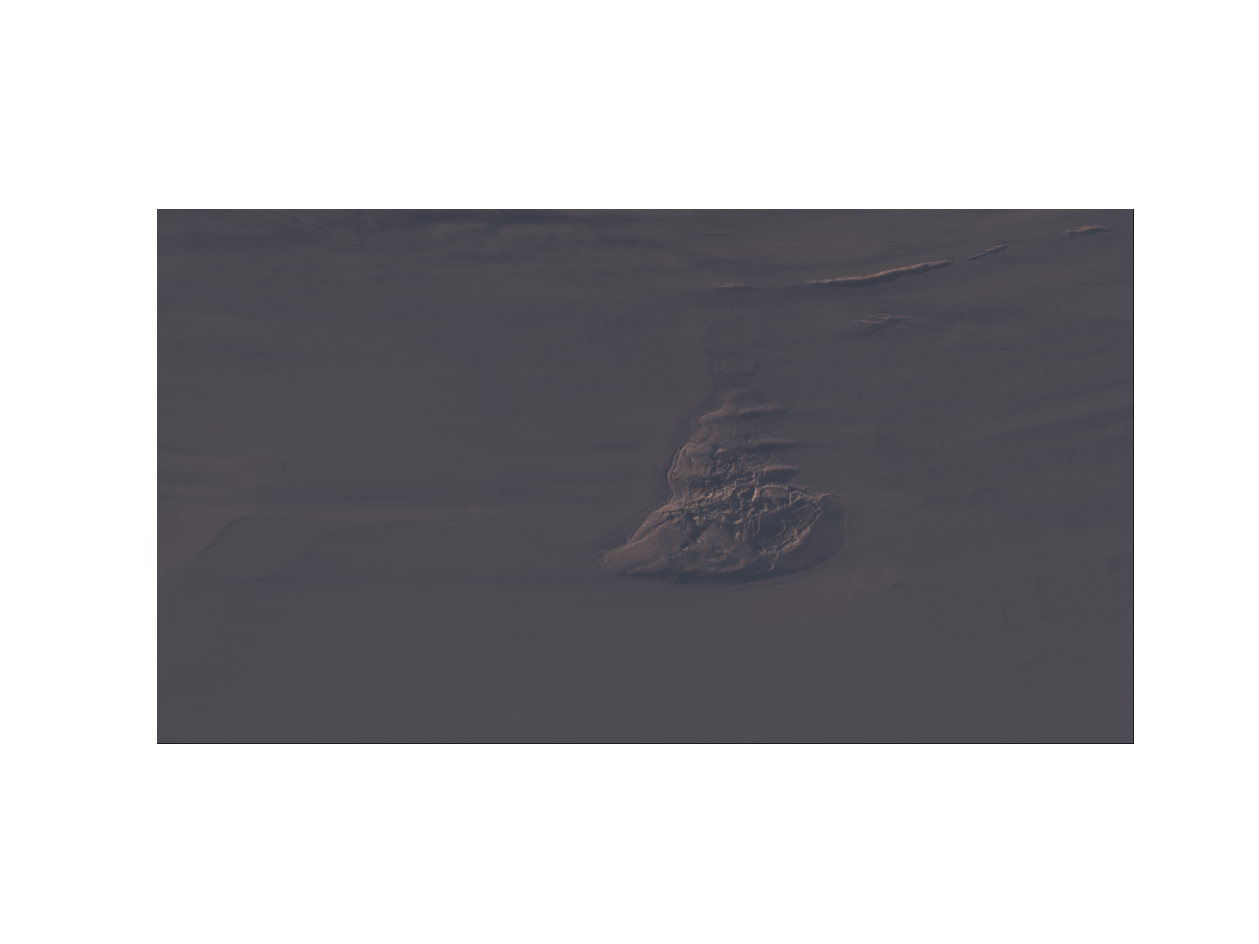

Wrote file data/L8/pansharpened/LC08_L1GT_126111_20190331_20190401_01_RT_pansharp_cropped_tci_8bit.tiff.


<IPython.core.display.Javascript object>


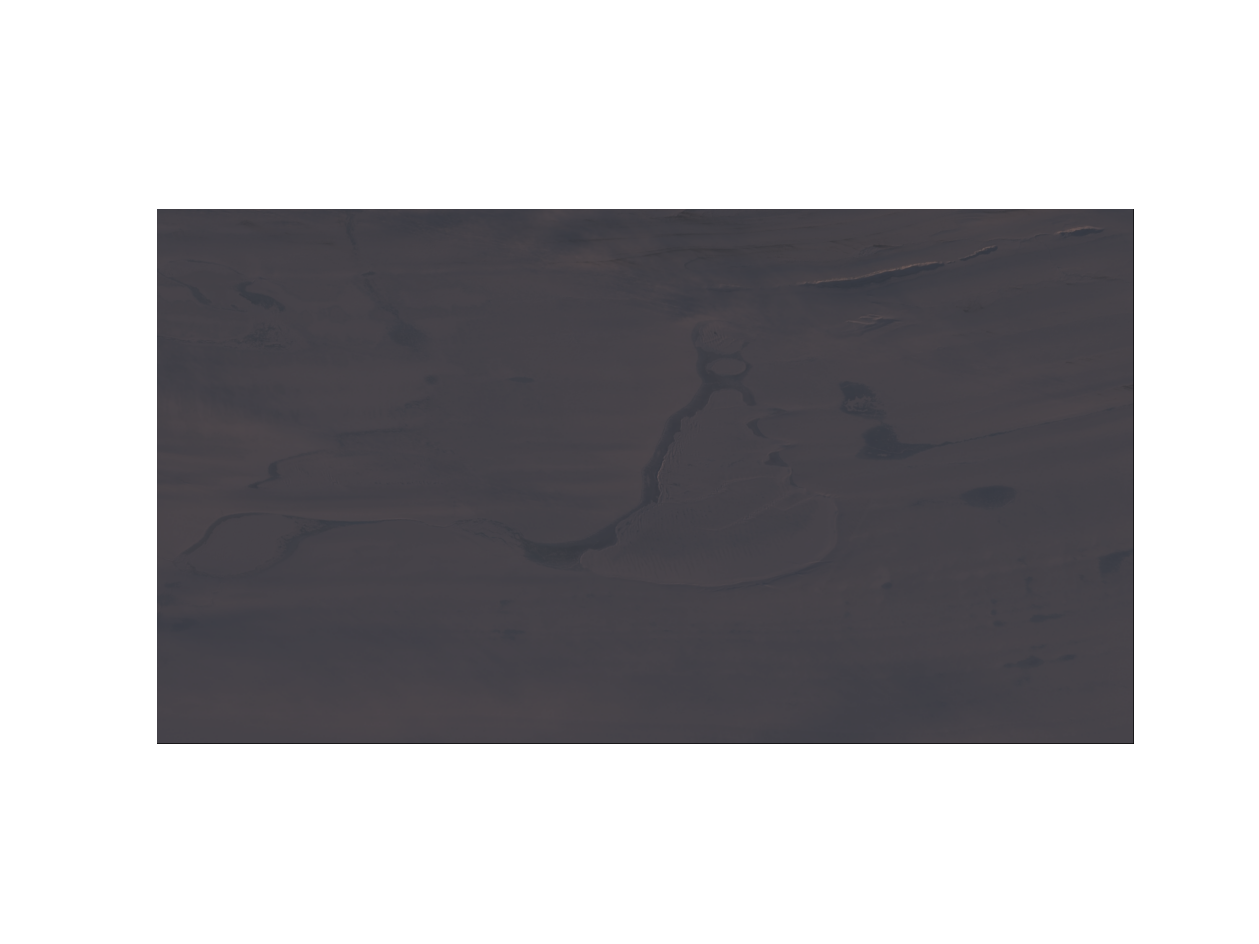

Wrote file data/L8/pansharpened/LC08_L1GT_126111_20200129_20200129_01_RT_pansharp_cropped_tci_8bit.tiff.


<IPython.core.display.Javascript object>


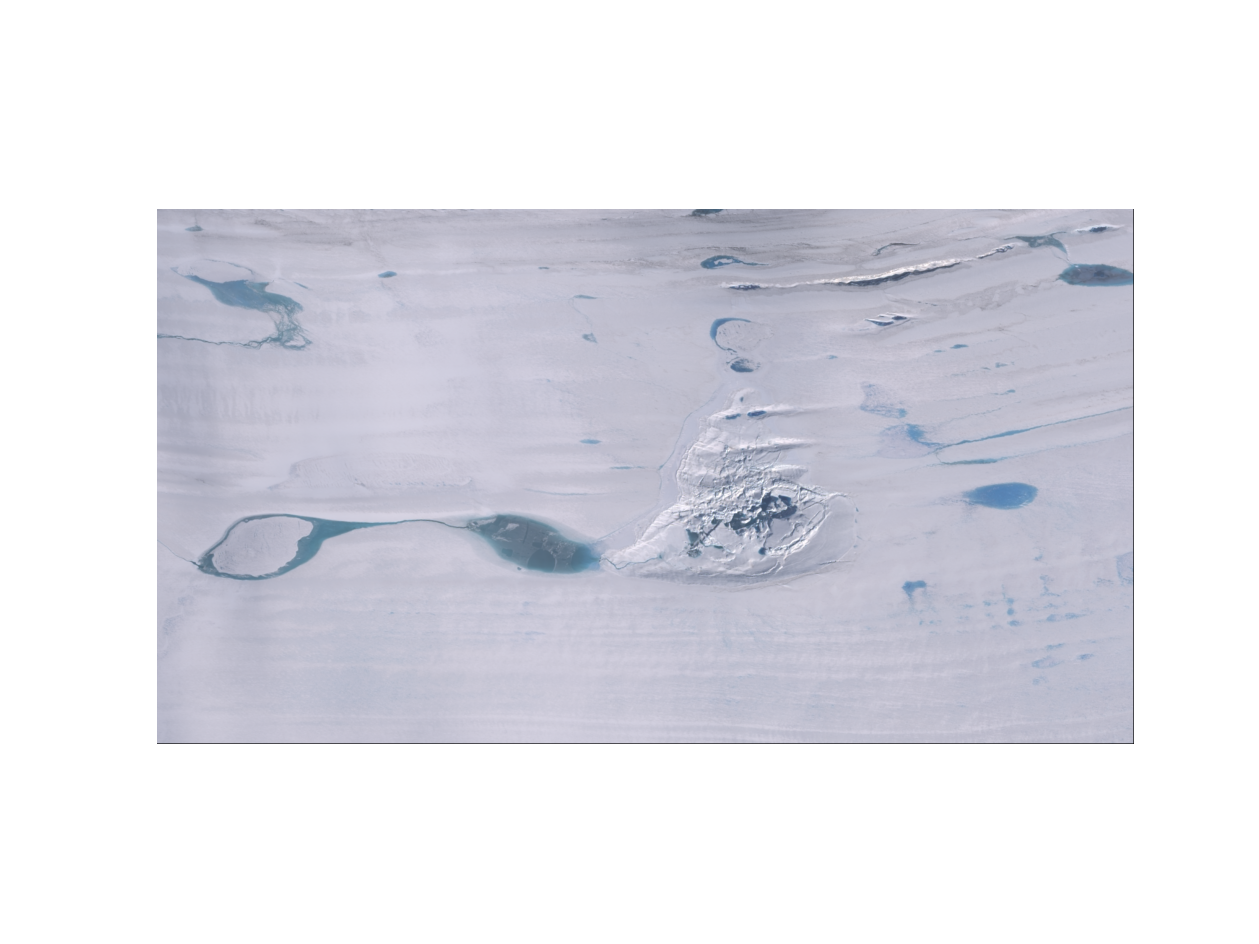

Wrote file data/L8/pansharpened/LC08_L1GT_127111_20200120_20200120_01_RT_pansharp_cropped_tci_8bit.tiff.


<IPython.core.display.Javascript object>


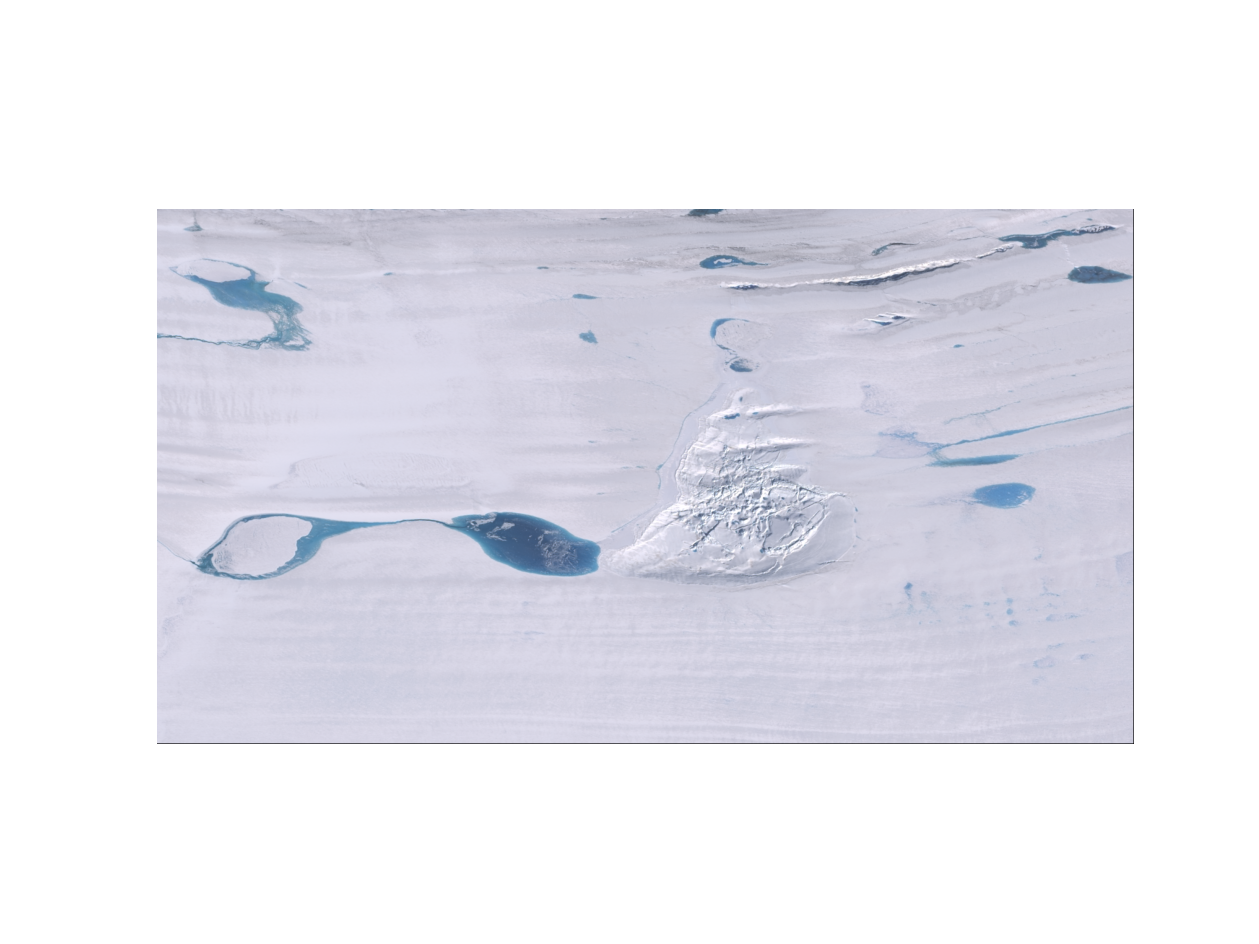

Wrote file data/L8/pansharpened/LC08_L1GT_128111_20190313_20190313_01_RT_pansharp_cropped_tci_8bit.tiff.


<IPython.core.display.Javascript object>


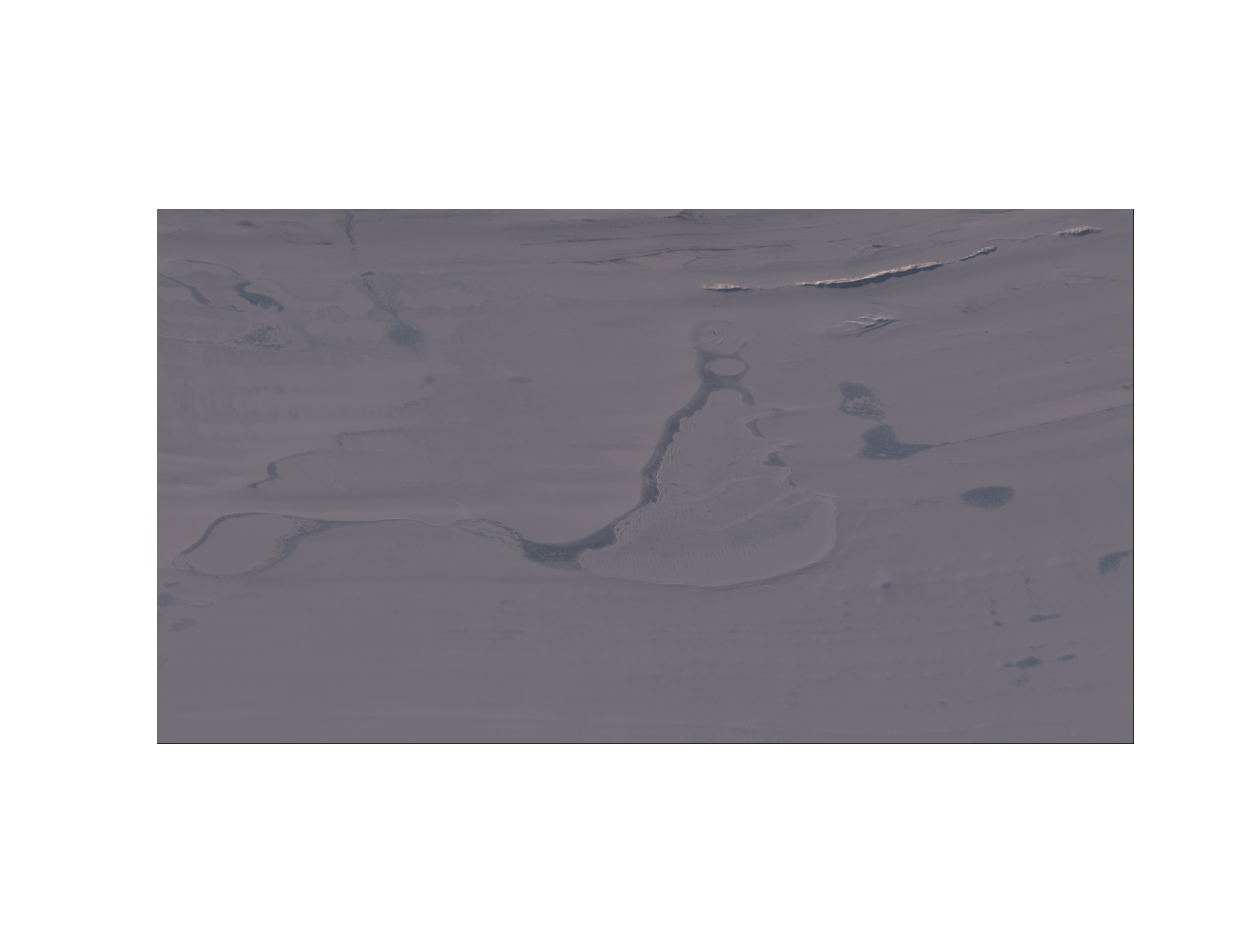

CPU times: user 8.11 s, sys: 1.12 s, total: 9.23 s
Wall time: 28.1 s


In [79]:
%%time
filelist = ['LC08_L1GT_127111_20190914_20190914_01_RT',
            'LC08_L1GT_126111_20190331_20190401_01_RT',
            'LC08_L1GT_126111_20200129_20200129_01_RT',
            'LC08_L1GT_127111_20200120_20200120_01_RT',
            'LC08_L1GT_128111_20190313_20190313_01_RT']
# filelist = ['LC08_L1GT_126111_20200129_20200129_01_RT']
for filename in filelist:
    pansharpLandsatS3(filename, localpath, limits, showimage=True)